# Kernel - PCA

In [12]:
#from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [251]:
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

In [1832]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

class Kernel_PCA(object):

    def __init__(self, X, Y, mode, gamma, degree, r): 

        self.X = X
        self.y = Y
        self.mode = mode
        self.gamma = gamma
        self.degree = degree
        self.r = r
        self.X_pc = self._kpca_implementation()


    def _kernels(self, x_i, x_j, mode):

        if mode == "rbf":
            return np.exp(-self.gamma * np.linalg.norm(x_i - x_j)**2)

        elif mode == "polynomial":
            return (self.gamma*np.dot(x_i,x_j) + self.r)**self.degree

        elif mode == "sigmoid":
            return np.tanh(self.gamma*np.dot(x_i,x_j) + self.r)


    def _kernel_matrix(self):

        n_samples = self.X.shape[0]
        kernel = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel[i,j] = self._kernels(self.X[i],self.X[j], self.mode)

        return kernel


    def _kpca_implementation(self, PC = 2):

        ## Calculate the Kernel matrix 
        K = self._kernel_matrix()

        ## Centering the symmetric  kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N,N)) / N
        K_ceter = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

        # Caculating eigne values and eigen vectors
        eigvals, eigvecs = eigh(K_ceter)

        # Calculating the new representation of X 
        X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,PC+1)))

        return X_pc
    


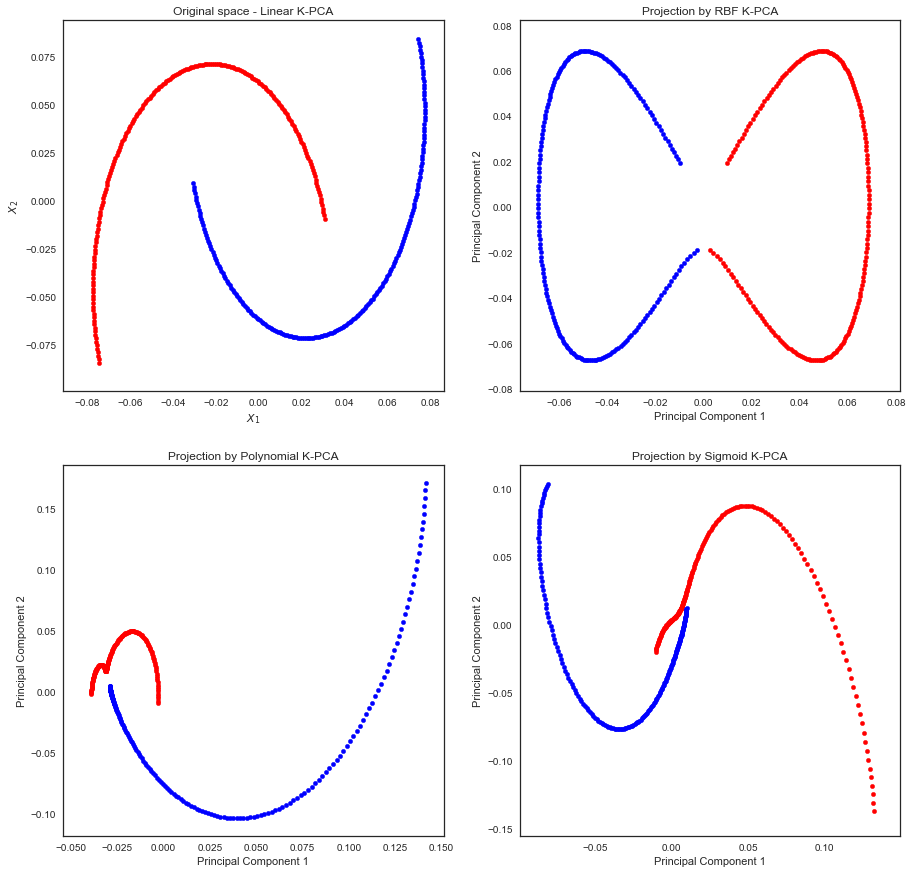

In [1840]:
plt.figure(figsize= (15,15))

np.random.seed(0)
#X, Y = make_circles(n_samples=400, factor=.3, noise=.05)
X, Y = make_moons(n_samples=n_samples, random_state=1)
reds = Y == 0
blues = Y == 1

mode_list = [['polynomial',1, 1, 1, 'Original space - Linear K-PCA', '$X_1$','$X_2$'], 
             ['rbf',12, 1, 1, 'Projection by RBF K-PCA', 'Principal Component 1','Principal Component 2'], 
             ['polynomial',3, 3, 1, 'Projection by Polynomial K-PCA', 'Principal Component 1','Principal Component 2'], 
             ['sigmoid',1, 1, 5, 'Projection by Sigmoid K-PCA', 'Principal Component 1','Principal Component 2']]

for n,i in enumerate(mode_list):
    
        mode, gamma, degree, r, title, x_axis, y_axis  = i
        kpca = Kernel_PCA(X, Y, mode, gamma, degree, r)
        X_pc = kpca.X_pc
        
        plt.subplot(2, 2, n+1)
        plt.title(title)
        plt.scatter(X_pc[reds, 0], X_pc[reds, 1], c="red", s=20)
        plt.scatter(X_pc[blues, 0], X_pc[blues, 1], c="blue",s=20)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
       
plt.show()

# Kernalised Kmeans

## Standard K-means

In [960]:
## Vanilla K-means

def assign(distances, rows, n_clusters, centers_temp, threshold = 0):
    
    global stability
    reassign_dict = dict()
    for i in range(n_clusters): reassign_dict[i] = list()

    for r in range(rows):
        temp = [dist_from_ref[i][r] for i in range(n_clusters)]
        reassign_dict[temp.index(min(temp))].append(min(temp))
        
    centers = center_calc(reassign_dict, n_clusters)
    if np.linalg.norm(centers - centers_temp) == threshold : stability = True
    
    return reassign_dict, centers


def center_calc(reassign_dict, n_clusters):
    
    temp_list = list()
    
    for n in range(n_clusters):
        temp_X = X[[j[0] for j in reassign_dict[n]]]
        temp_list.append([temp_X[:,0].mean(), temp_X[:,1].mean()])
    
    return np.array(temp_list)
    
    
def distance(x,x_i, mode = 'linear'):
    
    if mode == 'linear':
        return np.linalg.norm(x - x_i)
    
    elif mode == 'rbf':
        return np.exp(-GAMMA * np.linalg.norm(x - x_i)**2)
        

n_clusters = 4
stability = False 
GAMMA = 1

# selecting 'n_clusters' points at random
idx = random.sample(range(1, X.shape[0]), n_clusters)
centers_temp = X[idx]

chk = 0

while not stability:
    
    dist_from_ref = dict()

    for n in range(n_clusters):

        dist_from_ref[n] = list()
        for i in range(X.shape[0]):
            temp_dist =(i, distance(centers_temp[n],X[i], mode = 'linear'))
            dist_from_ref[n].append(temp_dist)
            
    
    dic, centers_temp = assign(dist_from_ref, X.shape[0], n_clusters, centers_temp)
    
    chk += 1
    if chk == 100: break


## Kernalized Kmeans

In [1974]:
"""
- Select dataset
- Select k centroids at random
- Create k clusters by assigning points randomly to the selected clusters
    - Calculate similarity between points and clusters in new space.
    - we get new clusters
    - repeat until stability
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles ,make_moons


class Kernel_KMEANS(object):


    def __init__(self, X, Y, mode, gamma, degree, r, n_clusters): 

        self.X = X
        self.y = Y
        self.mode = mode
        self.gamma = gamma
        self.degree = degree
        self.r = r
        self.n_clusters = n_clusters

        self.stability = False
        self.cluster_dict = dict()
        self.kernel =  np.zeros((X.shape[0], X.shape[0]))

        self._kmeans_implementation()


    def _kernels(self, x_i, x_j):

        if self.mode == "rbf":
            return np.exp(-self.gamma * np.linalg.norm(x_i - x_j)**2)

        elif self.mode == "polynomial":
            return (self.gamma*np.dot(x_i,x_j) + self.r)**self.degree

        elif self.mode == "sigmoid":
            return np.tanh(self.gamma*np.dot(x_i,x_j) + self.r )


    def _kernel_matrix(self):

        n_samples = self.X.shape[0]
        for i in range(n_samples):
            for j in range(n_samples):
                self.kernel[i,j] = self._kernels(self.X[i],self.X[j])


    def _random_cluster_assgin(self):

        n_samples = self.X.shape[0]
        shuffled_idx = list(np.random.permutation(n_samples))
        for cluster in range(self.n_clusters): self.cluster_dict[cluster] = list()
        for i in range(n_samples):
            random_centroid = random.randint(0, self.n_clusters-1)
            self.cluster_dict[random_centroid].append((shuffled_idx[i],self.X[shuffled_idx[i]]))



    def _third_term_obj_function(self,idx_list):

        output = 0
        for j in idx_list:
            for l in idx_list:
                output += self.kernel[j,l]

        # if statement to avoid division by zero
        if idx_list: return output/(len(idx_list)**2)
        else: return output


    def _second_term_obj_function(self, idx_list, i):

        output = 0
        for j in idx_list:
            output += self.kernel[i,j]

        # if statement to avoid division by zero
        if idx_list: return 2*output/len(idx_list)
        else: return output


    def _reassign(self, distance_dict, n_samples):

        temp_cluster_dict = dict()
        for cluster in range(self.n_clusters): temp_cluster_dict[cluster] = list()

        for i in range(n_samples):
            temp_list = [distance_dict[cluster][i] for cluster in range(self.n_clusters)]
            temp_cluster_dict[temp_list.index(min(temp_list))].append((i,self.X[i]))

        self._check(temp_cluster_dict) # checking if stability has been attained
        self.cluster_dict =  temp_cluster_dict



    def _check(self, temp_cluster_dict):

        temp_1 = [self.cluster_dict[0][i][0] for i in range(len(self.cluster_dict[0]))]
        temp_2 = [temp_cluster_dict[0][i][0] for i in range(len(temp_cluster_dict[0]))]

        if temp_1 == temp_2: self.stability = True



    def _kmeans_implementation(self):


        self._random_cluster_assgin() # Randomly assign points to clusters
        self._kernel_matrix()
        n_samples = self.X.shape[0]
        check = 0 # Check on infinite iterations

        while not self.stability:

            ## Caculating similarity/distance between points and clusters in new space

            distance_dict = dict()
            for cluster in range(self.n_clusters):

                distance_dict[cluster] = list()

                # Calculating 3rd term in objective function 
                temp_idx_list = [self.cluster_dict[cluster][i][0] for i in range(len(self.cluster_dict[cluster]))]
                third_term = self._third_term_obj_function(temp_idx_list)

                for i in range(n_samples):

                    # Calculating 2nd term in objective function
                    second_term = self._second_term_obj_function(temp_idx_list, i)

                    # Calculating the distance of instance 'i' from cluster
                    dist_i = self.kernel[i,i] - 2*second_term + third_term
                    distance_dict[cluster].append(dist_i)


            self._reassign(distance_dict, n_samples)   

            check += 1
            if check == 20 : break




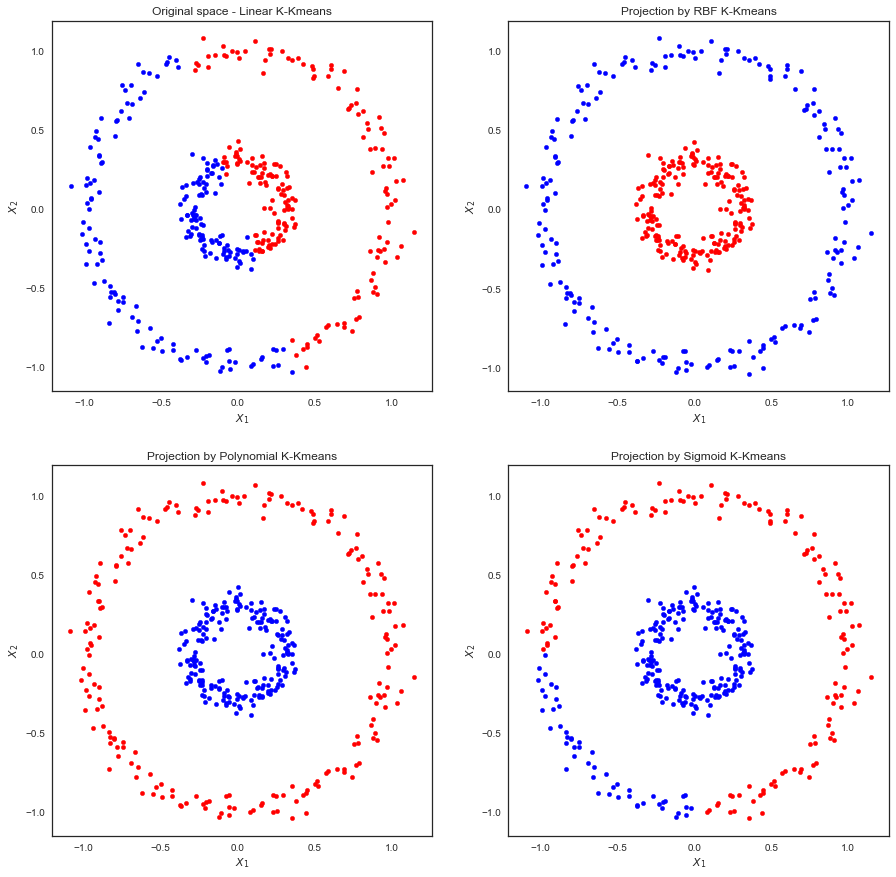

In [1975]:
plt.figure(figsize= (15,15))

np.random.seed(0)

n_samples = 400
n_clusters = 2
X, Y = make_circles(n_samples=n_samples, factor=.3, noise=.05, random_state=42)
#X, Y = make_moons(n_samples=n_samples, random_state=1)

mode_list = [['polynomial',1, 1, 1, 'Original space - Linear K-Kmeans', '$X_1$','$X_2$'], 
             ['rbf',5, 1, 1, 'Projection by RBF K-Kmeans', '$X_1$','$X_2$'], 
             ['polynomial',7, 4, 1, 'Projection by Polynomial K-Kmeans', '$X_1$','$X_2$'], 
             ['sigmoid',3, 1, 5, 'Projection by Sigmoid K-Kmeans', '$X_1$','$X_2$']]

for n,i in enumerate(mode_list):
    
        mode, gamma, degree, r, title, x_axis, y_axis  = i
        k_kmeans = Kernel_KMEANS(X, Y, mode, gamma, degree, r, n_clusters)
        cluster_dict = k_kmeans.cluster_dict
        #print(cluster_dict)
        #print("------------------------------------------")
        Y_ = np.ones((n_samples,))
        temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
        Y_[temp_list] = 0
        
        reds = Y_ == 0
        blues = Y_ == 1
        
        plt.subplot(2, 2, n+1)
        plt.title(title)
        plt.scatter(X[reds, 0], X[reds, 1], c="red", s=20)
        plt.scatter(X[blues, 0], X[blues, 1], c="blue",s=20)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        
plt.show()

In [1914]:
mode_list[0]

['polynomial', 1, 1, 1, 'Original space - Linear K-Kmeans', '$X_1$', '$X_2$']

In [1037]:
# Randomly create clusters
n_clusters = 3
shuffled_idx = list(np.random.permutation(X.shape[0]))
temp_dict = dict()
for i in range(n_clusters): 
    temp_idx = shuffled_idx[i*int(X.shape[0]/n_clusters):(i+1)*int(X.shape[0]/n_clusters)]
    temp_dict[i] = (temp_idx,X[temp_idx])
    
# calculate the distances
for i in range(X.shape[0]):
    for j in range(n_clusters):
        
    

## Helper functions
# primary distance function
def distance(kernel, cluster):
    
    for i in range
    second_term = 
    s_i = kernel
    
    


In [1048]:
X

array([[ -0.70564499,   8.55139891],
       [ -0.99796039,   3.16403005],
       [  2.82667347,   1.92710249],
       ..., 
       [ -1.01966506,   2.80165256],
       [ -1.79775432,   6.73688929],
       [ 10.48310534,  -3.73727439]])

In [1055]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=3,assign_labels="discretize",random_state=0).fit(X)
clustering.labels_

clustering

SpectralClustering(affinity='rbf', assign_labels='discretize', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=3, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=0)

In [1067]:
from sklearn import cluster, datasets
average = cluster.AgglomerativeClustering(n_clusters=2, linkage='average').fit(X)
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=average.labels_))

In [1213]:
Y_new = np.ones((400,))
temp = cluster_dict[0]
for i in temp:
    Y_new[i[0]] = 0

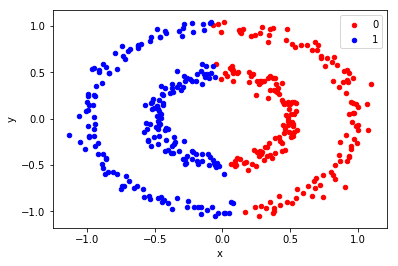

In [1218]:
# Plot the features 
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

plt.show()

# One Class SVM

In [ ]:
"""
- Given samples from the +ve class only
- The task is to detect outliers
- Useful in the following applications:
    - taking an image, if there's like a fingerprint or shit
    we can simply use one class learning (model trained on
    good images and classifier would know how a good photo
    looks like) to remove anomalies
- In SVDD, one should find the minimum circumsribing hyper-
ball in high dimensional space.
- The outliers are associated with outliers

Steps:
------
- Get/generate data set
- Define kernel matrix (gram matrix)
- Initialize weights (alpha, gamma, beta)
- Calculate the two parts of the loss function
- Calculate the loss
- Calculate new weights
- Update weights w.r.t weights
- Define the upadate 
"""

In [1409]:
## Helper functions
GAMMA =0.1
DEGREE = 2
R = 1
MODE = 'rbf'
## Helper Functions

# Kernel functions
def kernels(x_i, x_j, mode = MODE):

    if mode == "rbf":
        return np.exp(-GAMMA * np.linalg.norm(x_i - x_j)**2)

    elif mode == "polynomial":
        return (GAMMA*np.dot(x_i,x_j) + R) ** DEGREE

    elif mode == "sigmoid":
        return np.tanh(GAMMA*np.dot(x_i,x_j) + R)

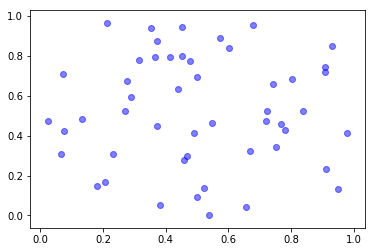

In [1407]:
## Generate Dataset 

import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(7)
N = 50
X_1 = np.random.rand(N)
X_2 = np.random.rand(N)

#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(X_1, X_2, c='blue', alpha=0.5)
plt.show()

# Data prep  
X_1 = np.array(X_1, ndmin=2).T
X_2 = np.array(X_2, ndmin=2).T
X = np.concatenate((X_1,X_2), axis = 1)


In [1417]:
## Define kernel matrix 

k = np.zeros((X.shape[0],X.shape[0]))
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        k[i,j] = kernels(X[i], X[j])

In [1426]:
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
solve((x**2 + 4*x + 5), x)


[-2 - I, -2 + I]

In [1446]:
from sklearn.datasets import make_blobs
#X,Y = make_blobs(centers=1)
X, Y = make_circles(n_samples, factor= 0.3, noise= 0.05, random_state=42)
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))

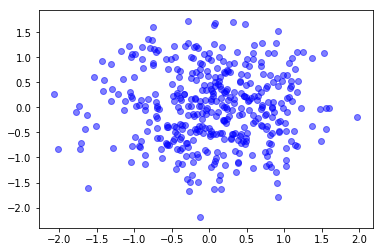

In [1435]:
color = {0:'blue', 1:'red'}
plt.scatter(X[:,0], X[:,1], c=color, alpha=0.5)
plt.show()

In [1757]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable

In [1758]:
num_data = 1000 
num_epoch = 10

noise = init.normal(torch.FloatTensor(num_data,2),std=0.2)
x = init.uniform(torch.Tensor(num_data,2),-10,10)

y = 2*x[:,0]+3
y_noise = 2*(x[:,0]+noise[:,0])+3

model = nn.Linear(2,1)
output = model(Variable(x))

loss_func = nn.L1Loss()
optimizer = optim.SGD(model.parameters(),lr=0.01)


# train
loss_arr =[]
label = Variable(y_noise)
for i in range(num_epoch):
    output = model(Variable(x))
    optimizer.zero_grad()

    loss = loss_func(output,label)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(loss)
    loss_arr.append(loss.data.numpy())

/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/Users/allwynjoseph/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


RuntimeError: input and target shapes do not match: input [1000 x 1], target [1000] at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/THNN/generic/AbsCriterion.c:12

# Archive

## Kernalised K means

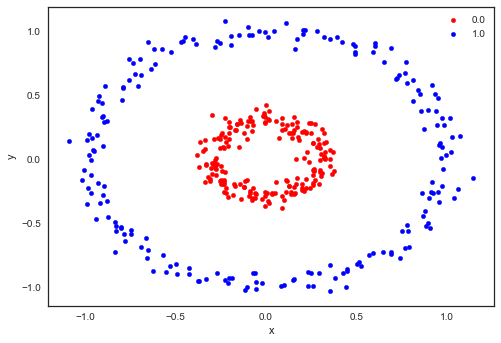

In [1977]:

GAMMA = 4
DEGREE = 4
R = 5
MODE = 'rbf'
## Helper Functions

# Kernel functions
def kernels(x_i, x_j, mode = MODE):

    if mode == "rbf":
        return np.exp(-GAMMA * np.linalg.norm(x_i - x_j)**2)

    elif mode == "polynomial":
        return (GAMMA*np.dot(x_i,x_j) + R) ** DEGREE

    elif mode == "sigmoid":
        return np.tanh(GAMMA*np.dot(x_i,x_j) + R)
    
# Function to calculate the third term in the dist equation
def _third_term(idx_list, kernel):

    temp = 0
    for j in idx_list:
        for l in idx_list:
            temp += kernel[j,l]
    
    if idx_list: return temp/(len(idx_list)**2)
    else: return temp


# Function to calculate the second term in the dist equation
def _second_term(idx_list, kernel, i):
    
    temp = 0
    for j in idx_list:
        temp += kernel[i,j]
   
    if idx_list: return 2*temp/len(idx_list)
    else: return temp
    

# Function to reassign instances to respective clusters based on distance
def _reassign(dist_dict, n_samples, n_clusters, X):
    
    global cluster_dict, stability
    
    temp_cluster_dict = dict()
    for c in range(n_clusters): temp_cluster_dict[c] = list()
    for i in range(n_samples):
        
        temp_list = [dist_dict[c][i] for c in range(n_clusters)]
        temp_cluster_dict[temp_list.index(min(temp_list))].append((i,X[i]))
    
    check(temp_cluster_dict)
    
    return temp_cluster_dict
        
    
# checking if stability has been attained
def check(temp_cluster_dict):
  
    global cluster_dict, stability
    temp_1 = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
    temp_2 = [temp_cluster_dict[0][i][0] for i in range(len(temp_cluster_dict[0]))]
    
    if temp_1 == temp_2:stability = True
        
    

## Select dataset
n_samples=400
#X, Y = make_moons(n_samples=n_samples, random_state=1)
#df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
X, Y = make_circles(n_samples, factor= 0.3, noise= 0.05, random_state=42)
#X,Y = make_blobs(400, 2,centers = 2,random_state=2)
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))

## Select k centroids at random
n_clusters = 2
#random.seed(1)
idx = random.sample(range(1, X.shape[0]), n_clusters)
centers_temp = X[idx]

## Create k clusters by assigning points randomly to the selected clusters
# dict where key is cluster number and the value is a list of tuples containting 
# idx and instance coordinates (323, array([3.233, 0.44334]))
cluster_dict = dict() 
shuffled_idx = list(np.random.permutation(n_samples))
for c in range(n_clusters): cluster_dict[c] = list()
for i in range(n_samples): 
    random_centroid = random.randint(0,n_clusters-1)
    cluster_dict[random_centroid].append((shuffled_idx[i],X[shuffled_idx[i]]))

## Caculating the kernel matrix
kernel = np.ones((n_samples, n_samples))
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        kernel[i,j] = kernels(X[i],X[j])
        

chk = 0
stability = False
while not stability:
    
    #print(chk)
    chk += 1

    ## Caculating similarity/distance between points and clusters in new space
    
    dist_dict = dict() # dict containing distance of points and clusters

    for c in range(n_clusters):
        
        dist_dict[c] = list()
        # Calculating the 3rd term in the distance equation
        temp_idx_list = [cluster_dict[c][i][0] for i in range(len(cluster_dict[c]))]
        third_term = _third_term(temp_idx_list, kernel)
        for i in range(n_samples):
             # Calculating the 2nd term in the distance equation
            second_term = _second_term(temp_idx_list, kernel, i)
        
            # Calculating the distance and appending to a list
            dist_i = kernel[i,i] - 2*second_term + third_term
            dist_dict[c].append(dist_i)
            
    cluster_dict = _reassign(dist_dict, n_samples, n_clusters, X)   
    if chk == 20 : break
            

## Plotting
Y_ = np.ones((n_samples,))
temp_list = [cluster_dict[0][i][0] for i in range(len(cluster_dict[0]))]
Y_[temp_list] = 0
df_temp = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y_))
colors = {0:'red', 1:'blue', 2:'green', 3:'pink'}
fig, ax = plt.subplots()
grouped = df_temp.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

plt.show()